Across the 3 feature spaces searched (all features (19638), those features that are present in the Cancer Cell Map) we will have 3x(25 choose 2) = 900 total interactions. 

We want to further filter these interactions according to effect size and significance. Since our genetic algorithm optimized for fitness using the t-statistic, we need alternative calculations of statistical significance. 

In [1]:
import os
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 42 + 3

n_cores = 60
os.environ["OMP_NUM_THREADS"] = str(1)
os.environ["MKL_NUM_THREADS"] = str(1)
os.environ["OPENBLAS_NUM_THREADS"] = str(1)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(1)
os.environ["NUMEXPR_NUM_THREADS"] = str(1)


In [2]:

import itertools
import random
from multiprocessing import Pool
from math import comb
import copy
from collections import defaultdict


from tqdm import tqdm, trange 

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import KFold
from sklearn.base import clone



import seaborn as sns
import matplotlib.pyplot as plt 

import sys
sys.path.insert(1, '../../')
from utils import read_pickled_object, get_stats, cohen_d



/orcd/pool/005/hmbaghda/miniforge3/envs/metastatic_potential/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocess

Same as [Notebook 05A](./05A_top_ranked_interactions.ipynb)

In [3]:
# load data
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
expr_joint = X.copy()

mp_joint=pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean']
y = mp_joint.values.ravel()

expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)

protein_cols = expr_protein.columns
rna_cols = expr_rna.columns

X_protein = X[protein_cols].values
X_rna = X[rna_cols].values

# fit model
best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 
                                                 'best_model_svr_linear_joint.pickle'))

X = (X_protein, X_rna)
best_pipeline = clone(best_pipeline)
best_pipeline.fit(X, y)


model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
if not np.allclose(model_coefs['SVM coefficient'].values, 
                   best_pipeline.named_steps['model'].coef_.flatten()):
    raise ValueError('Inconsitency between Notebook 04 and 05')
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.set_index('feature_name', inplace = True)

# get prediction
y_pred = best_pipeline.predict(X)
residuals = y - y_pred

# center
X_map = {'Transcriptomics': X_rna, 'Proteomics': X_protein}
X_map = {k: X_ - np.mean(X_, axis=0) for k, X_ in X_map.items()} # center the data

/orcd/pool/005/hmbaghda/miniforge3/envs/metastatic_potential/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/orcd/pool/005/hmbaghda/miniforge3/envs/metastatic_potential/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [4]:
def get_interaction_value_ols(feature_1: str, feature_2: str, residuals, X_map, model_coefs):
    X_1 = X_map[model_coefs.loc[feature_1,'Modality']][:, model_coefs.loc[feature_1, 'feature_index']]
    X_2 = X_map[model_coefs.loc[feature_2,'Modality']][:, model_coefs.loc[feature_2, 'feature_index']]

    ols_df = pd.DataFrame({"residual": residuals, 
                           "X_tilda": X_1 * X_2})

    ols_interaction = smf.ols("residual ~ X_tilda", data=ols_df).fit()


    coef = float(ols_interaction.params.X_tilda)
    pval = float(ols_interaction.pvalues.X_tilda)
    
    se = ols_interaction.bse.X_tilda
    
    t_statistic = float(abs(coef))/se
    
    return coef, pval, t_statistic

Let's see how the genetic algorithm looked for each feature set:

In [5]:
fn_map = {'all': '', 
          'cancer_gene_consensus': 'cgc', 
          'cancer_cell_map': 'ccm'}

fn = 'v3'

In [6]:
ols_scores_ga = {}
ols_best_set = {}

for feature_type, fn in fn_map.items():
    fn = 'v3' + fn
    score_tracker = pd.read_csv(os.path.join(data_path, 'processed', 'joint_interaction_residuals_ga_scores_sets' + fn + '.csv'), 
                               index_col = 0)
    with open(os.path.join(data_path, 'interim', 'joint_interaction_residuals_ga_solution_sets' + fn + '.txt'), "r") as f:
        best_set = [line.strip() for line in f]

    # if not v2:
    #     if not np.allclose(evaluate_solution(best_set), 
    #                        score_tracker.max().max()):
    #         raise ValueError('The best set is incongruous with the final generation')

    ols_scores_ga[feature_type] = score_tracker
    ols_best_set[feature_type] = best_set

    print("Best score for " + feature_type + ": {:.4f}".format(score_tracker.max().max()))


Best score for all: 0.5002
Best score for cancer_gene_consensus: 0.4875
Best score for cancer_cell_map: 0.5027


''

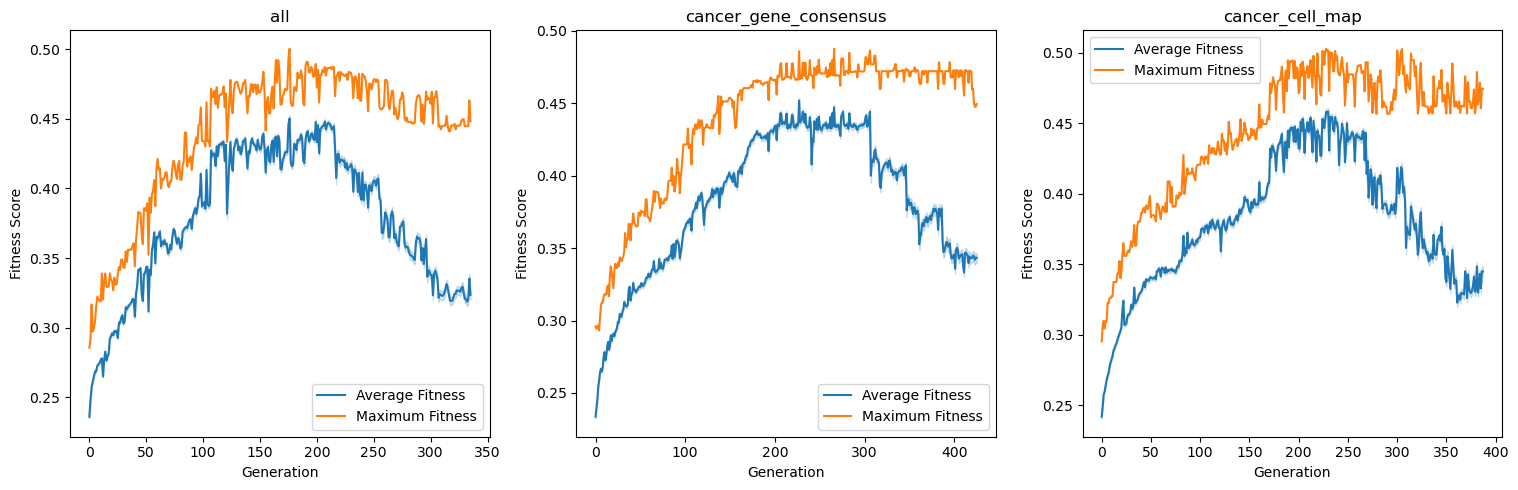

In [7]:
ncols = len(ols_scores_ga)
fig , ax = plt.subplots(ncols = ncols, figsize = (5.1*ncols,5))

for i, (feature_type, score_tracker) in enumerate(ols_scores_ga.items()):
    viz_df = score_tracker.copy()
    viz_df['generation'] = range(viz_df.shape[0])
    viz_df = pd.melt(viz_df, id_vars='generation', value_name='fitness_score')
    sns.lineplot(data = viz_df, x = 'generation', y = 'fitness_score', label = 'Average Fitness', ax = ax[i])

    viz_df = pd.DataFrame(score_tracker.max(axis = 1), columns = ['fitness_score'])
    viz_df.reset_index(names = 'generation', inplace = True)
    sns.lineplot(data = viz_df, x = 'generation', y = 'fitness_score', label = 'Maximum Fitness', ax = ax[i])
    ax[i].set_ylabel('Fitness Score')
    ax[i].set_xlabel('Generation')
    
    ax[i].set_title(feature_type)
    
fig.tight_layout()
;


Next, let's get the interactions from the OLS methodology for each set:

In [8]:
ols_res = pd.DataFrame(columns = ['feature_1', 'feature_2', 'coef', 'pval', 't_statistic', 'feature_type'])
for feature_type, best_set in ols_best_set.items():
    feature_combs = list(itertools.combinations(best_set, 2))

    res_all = []
    for feature_comb in tqdm(feature_combs):
        res = get_interaction_value_ols(feature_comb[0], feature_comb[1], residuals, X_map, model_coefs)
        res_all.append(res)

    res_all = pd.DataFrame(res_all, columns = ['coef', 'pval', 't_statistic'])
    _, bh_fdr, _, _ = multipletests(res_all.pval, method='fdr_bh')
    res_all['bh_fdr'] = bh_fdr

    res_all = pd.concat([
        pd.DataFrame(feature_combs, columns = ['feature_1', 'feature_2']),
        res_all
    ],
        axis = 1)
    
    res_all['feature_type'] = feature_type
    
    ols_res = pd.concat([ols_res, res_all], axis = 0)

100%|████████████████████████████████████████| 300/300 [00:00<00:00, 459.50it/s]
/tmp/ipykernel_3803072/837090412.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ols_res = pd.concat([ols_res, res_all], axis = 0)
100%|████████████████████████████████████████| 300/300 [00:00<00:00, 463.92it/s]


In [9]:
duplicated_idx = list(np.where(ols_res[['feature_1', 'feature_2']].duplicated())[0])
ols_res[(ols_res.feature_1 == 'APC (324)') & (ols_res.feature_2 == 'AXIN1 (8312)')]

,feature_1,feature_2,coef,pval,t_statistic,feature_type,bh_fdr
126,APC (324),AXIN1 (8312),-0.185422,0.004566,2.862589,cancer_gene_consensus,0.120022
153,APC (324),AXIN1 (8312),-0.185422,0.004566,2.862589,cancer_cell_map,0.098476


Let's see how the t-statistic vs coefficient contributed to thes score:

''

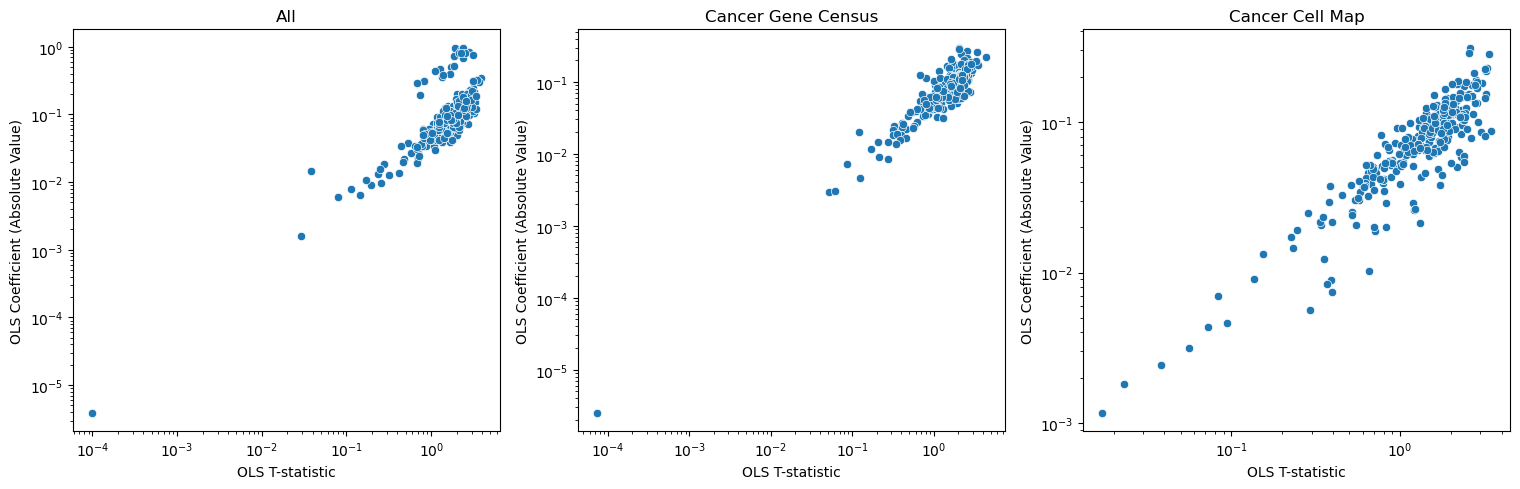

In [10]:
ncols = ols_res.feature_type.nunique()
fig, ax = plt.subplots(ncols = ncols, nrows = 1, figsize = (5.1*ncols, 5))

ft_map = {'all': 'All', 
                         'cancer_gene_consensus': 'Cancer Gene Census', 
                         'cancer_cell_map': 'Cancer Cell Map'}

top_panel = {}
for i, feature_type in enumerate(ols_res.feature_type.unique()):
    viz_df = ols_res[ols_res.feature_type == feature_type]
    top_panel[feature_type] = viz_df

    sns.scatterplot(y = viz_df.coef.abs(), x = viz_df.t_statistic, ax = ax[i])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    
    ax[i].set_ylabel('OLS Coefficient (Absolute Value)')
    ax[i].set_xlabel('OLS T-statistic')
    
    ax[i].set_title(ft_map[feature_type])

fig.tight_layout()
;

Unlike previously, effect sizes and t-statistics were comparable across all 3 gene sets. As a reminder, previously (old feature selection method), for all geneswe identified some coefficients with very strong effect sizes, but that potentially also have high standard errors. The purpose of weighting both components in the GA is to prevent pure selection of high coefficients. 

In [11]:
ols_res.to_csv(os.path.join(data_path, 'interim', 'ols_interactions_all.csv'))

# Filter 

Next, let's filter for our most promising interactions across the three sets:

In [12]:
ols_res = pd.read_csv(os.path.join(data_path, 'interim', 'ols_interactions_all.csv'))

In [13]:
ols_res[ols_res.bh_fdr <= 0.1].feature_type.value_counts()

feature_type
all                      75
cancer_cell_map          15
cancer_gene_consensus     4
Name: count, dtype: int64

Based on the above significance thresholds, we retain only those interactions with a BH FDR <= 0.15.

In [15]:
# ols_res = ols_res[((ols_res.feature_type.isin(['cancer_cell_map', 'cancer_gene_consensus'])) & (ols_res.bh_fdr <= 0.15)) |
#        ((ols_res.feature_type.isin(['all'])) & (ols_res.bh_fdr <= 0.2))]

ols_res = ols_res[ols_res.bh_fdr <= 0.1]

ols_res.feature_type.value_counts()


feature_type
all                      75
cancer_cell_map          15
cancer_gene_consensus     4
Name: count, dtype: int64

In [16]:
ols_res = ols_res.sort_values(by='t_statistic', key=lambda x: x.abs(), ascending=False)


''

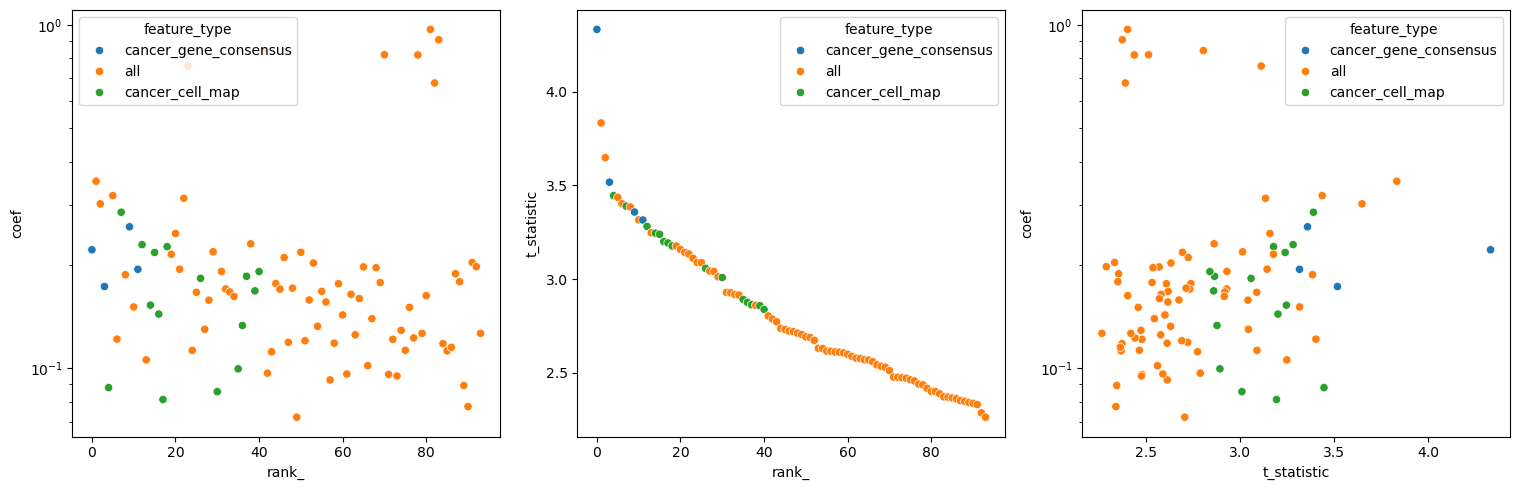

In [17]:
fig, ax = plt.subplots(ncols = 3, figsize = (15.3, 5))

viz_df = ols_res.copy()
viz_df['rank_'] = range(viz_df.shape[0])
viz_df['coef'] = viz_df.coef.abs()

viz_df_b = viz_df.copy()

sns.scatterplot(data = viz_df, x = 'rank_', y = 'coef', hue = 'feature_type', ax = ax[0])
ax[0].set_yscale('log')
sns.scatterplot(data = viz_df, x = 'rank_', y = 't_statistic', hue = 'feature_type', ax = ax[1])
sns.scatterplot(data = viz_df, x = 't_statistic', y = 'coef', hue = 'feature_type', ax = ax[2])
ax[2].set_yscale('log')

fig.tight_layout()
;


Upon rank ordering by t-statistics, we can see that those with the largest effect sizes (absolute value of coefficient) do not necessarily have the largest t-statistics. This tells us that sometimes those values with large effect sizes also have large standard errors. Thus, of our remaining 94 interactions, we will heuristically take the top 50 to examine further. 

In [18]:
top_n_interactions = 50
ols_res = ols_res.iloc[:top_n_interactions, :].reset_index(drop=True)
ols_res.feature_type.value_counts()

feature_type
all                      31
cancer_cell_map          15
cancer_gene_consensus     4
Name: count, dtype: int64

Figure for paper:

In [19]:
viz_df_b

,Unnamed: 0,feature_1,feature_2,coef,pval,t_statistic,feature_type,bh_fdr,rank_
514,214,FOXL2 (668),USP8 (9101),0.221516,0.000022,4.331962,cancer_gene_consensus,0.006471,0
166,166,ZC3H10 (84872),SLX4 (84464),0.350830,0.000161,3.832716,all,0.048296,1
168,168,ZC3H10 (84872),RDH11 (51109),0.301427,0.000323,3.647630,all,0.048296,2
492,192,GPHN (10243),AXIN1 (8312),0.173149,0.000520,3.516888,cancer_gene_consensus,0.078026,3
669,69,LEF1 (51176),HTT (3064),0.087878,0.000672,3.445044,cancer_cell_map,0.063029,4
...,...,...,...,...,...,...,...,...,...
42,42,TBC1D5 (9779),SELENOI (85465),0.089126,0.019998,2.341698,all,0.084313,89
9,9,PLXNA3 (55558),DHX30 (22907),0.077406,0.020235,2.337199,all,0.084313,90
213,213,SLX4 (84464),COX10 (1352),0.203505,0.020595,2.330448,all,0.084637,91
172,172,ZC3H10 (84872),WDR36 (134430),0.197768,0.023098,2.286171,all,0.093642,92


In [20]:
high_confidence = ols_res.feature_1.astype('str') + '^' + ols_res.feature_2.astype('str')
all_perm = viz_df_b.feature_1.astype('str') + '^' + viz_df_b.feature_2.astype('str')
# high_confidence = viz_df_b[all_perm.isin(high_confidence)].index.tolist()

In [21]:
high_confidence.shape

(50,)

In [22]:
all_perm.shape

(94,)

In [23]:
viz_df_b.shape

(94, 9)

In [24]:
viz_df_b.reset_index(drop = True, inplace = True)
high_confidence = ols_res.feature_1.astype('str') + '^' + ols_res.feature_2.astype('str')
all_perm = viz_df_b.feature_1.astype('str') + '^' + viz_df_b.feature_2.astype('str')
high_confidence = viz_df_b[all_perm.isin(high_confidence)].index.tolist()

viz_df_b['Included in Downstream Permutation Interaction Assessment'] = False
viz_df_b.loc[high_confidence, 'Included in Downstream Permutation Interaction Assessment'] = True
viz_df_b.feature_type = viz_df_b.feature_type.map(ft_map)
viz_df_b.rename(columns = {'feature_type': 'Starting Feature Search Space'}, inplace = True)


''

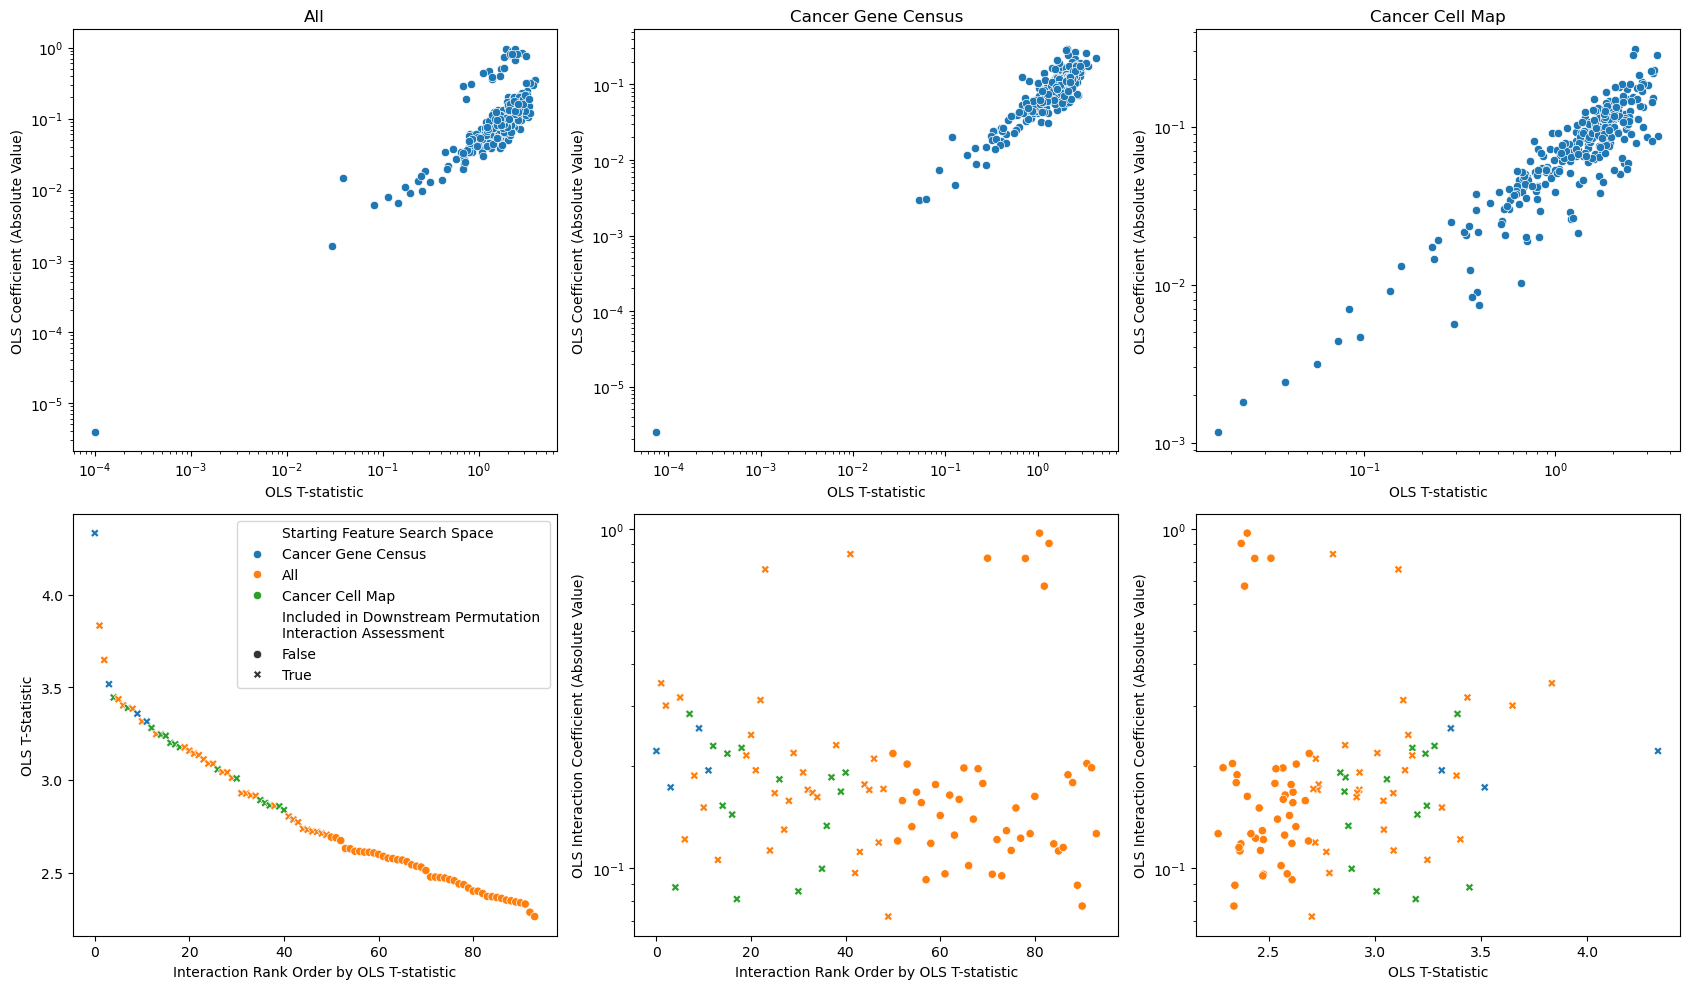

In [25]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (17, 10))

i = 0
for j, (feature_type, viz_df) in enumerate(top_panel.items()):
    sns.scatterplot(y = viz_df.coef.abs(), x = viz_df.t_statistic, ax = ax[i, j])
    ax[i, j].set_xscale('log')
    ax[i, j].set_yscale('log')
    
    ax[i, j].set_ylabel('OLS Coefficient (Absolute Value)')
    ax[i, j].set_xlabel('OLS T-statistic')
    
    ax[i, j].set_title(ft_map[feature_type])


i = 1
j = 0
sns.scatterplot(data = viz_df_b, 
                x = 'rank_', 
                y = 't_statistic', 
                hue = 'Starting Feature Search Space',
                style = 'Included in Downstream Permutation Interaction Assessment',
               ax = ax[i,j]) 
ax[i,j].set_ylabel('OLS T-Statistic')
ax[i,j].set_xlabel('Interaction Rank Order by OLS T-statistic')

handles, labels = ax[i,j].get_legend_handles_labels()

lti = labels[4].index('Interaction')
labels[4] = labels[4][:lti] + '\n' + labels[4][lti:]
ax[i,j].legend(handles, labels)


j = 1
sns.scatterplot(data = viz_df_b, 
                x = 'rank_', 
                y = 'coef', 
                hue = 'Starting Feature Search Space',
                style = 'Included in Downstream Permutation Interaction Assessment',
               ax = ax[i,j]) 
ax[i,j].set_ylabel('OLS Interaction Coefficient (Absolute Value)')
ax[i,j].set_yscale('log')
ax[i,j].set_xlabel('Interaction Rank Order by OLS T-statistic')
ax[i,j].legend_.remove()

j = 2
sns.scatterplot(data = viz_df_b, 
                x = 't_statistic', 
                y = 'coef', 
                hue = 'Starting Feature Search Space',
                style = 'Included in Downstream Permutation Interaction Assessment',
               ax = ax[i,j]) 
ax[i,j].set_ylabel('OLS Interaction Coefficient (Absolute Value)')
ax[i,j].set_yscale('log')
ax[i,j].set_xlabel('OLS T-Statistic')
ax[i,j].legend_.remove()

fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'SHH.png'), 
            dpi=300, 
            bbox_inches="tight")  
;


''

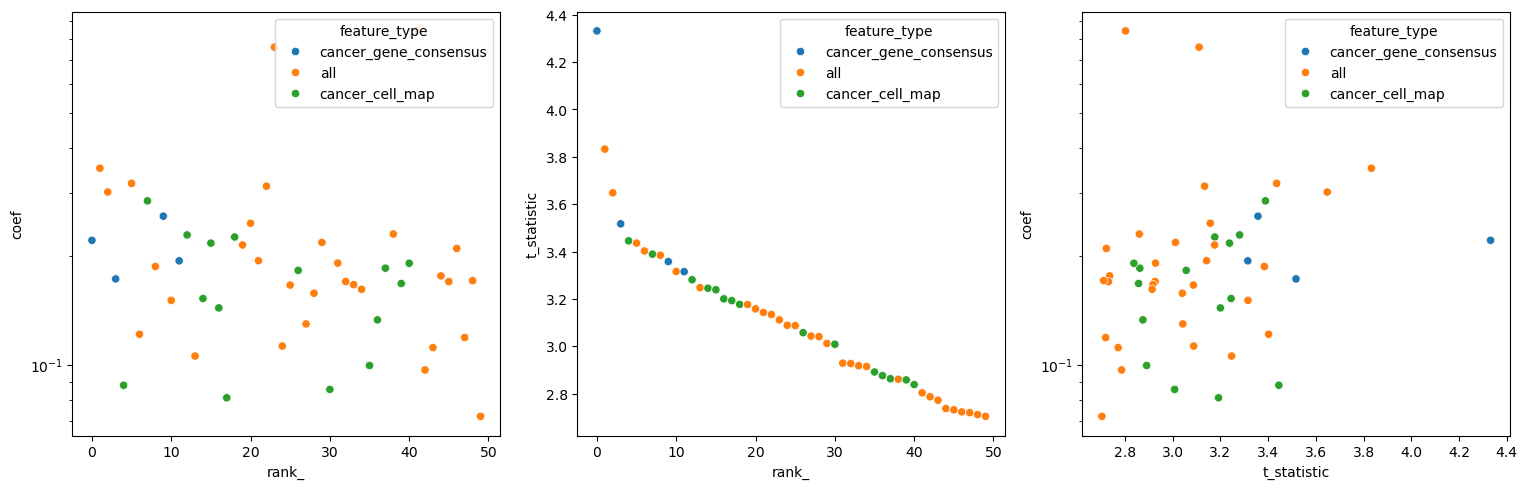

In [26]:
fig, ax = plt.subplots(ncols = 3, figsize = (15.3, 5))

viz_df = ols_res.copy()
viz_df['rank_'] = range(viz_df.shape[0])
viz_df['coef'] = viz_df.coef.abs()

sns.scatterplot(data = viz_df, x = 'rank_', y = 'coef', hue = 'feature_type', ax = ax[0])
ax[0].set_yscale('log')
sns.scatterplot(data = viz_df, x = 'rank_', y = 't_statistic', hue = 'feature_type', ax = ax[1])
sns.scatterplot(data = viz_df, x = 't_statistic', y = 'coef', hue = 'feature_type', ax = ax[2])
ax[2].set_yscale('log')

fig.tight_layout()
;


This filtering approach prioritized significant interactions from the OLS over those with strong effects, while maintaining a reasonable balance of having some strong effect interactions (particularly from the all gene set) and a reasonable number of interactions from each of the 3 searched gene sets. 

In [27]:
duplicated = ols_res[ols_res[['feature_1', 'feature_2']].duplicated()]
duplicated = duplicated.feature_1.astype('str') + '&' + duplicated.feature_2.astype('str')
ols_res[(ols_res.feature_1.astype('str') + '&' + ols_res.feature_2.astype('str')).isin(duplicated)]

,Unnamed: 0,feature_1,feature_2,coef,pval,t_statistic,feature_type,bh_fdr


In [28]:
# interaction_counts = pd.Series(ols_res.feature_1.tolist() + ols_res.feature_2.tolist()).value_counts()
# genes_to_keep = interaction_counts[interaction_counts >= 5].index.tolist()

In [29]:
ols_res.to_csv(os.path.join(data_path, 'interim', 'filtered_ols_interactions.csv'))

# Assess Significance: Permutation Test

Since we used the t-statistic as part of the fitness score in the genetic algorithm, we cannot directly use these p-values to assess the significance of the interaction. Thus, we use an alternative permutation test to assess signifiance. 

Amongst our list of 50 interactions, we will retain those with a BH FDR <= 0.1 for further exploration. 

In [30]:
# re-load data
model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
model_coefs.set_index('feature_name', inplace = True)

ols_res = pd.read_csv(os.path.join(data_path, 'interim', 'filtered_ols_interactions.csv'), 
                     index_col = 0)

In [31]:
ols_res.feature_type.value_counts()
# feature_counts = pd.Series(ols_res.feature_1.tolist() + ols_res.feature_2.tolist()).value_counts()
# recurring_genes = feature_counts[feature_counts >= 4].index.tolist()

feature_type
all                      31
cancer_cell_map          15
cancer_gene_consensus     4
Name: count, dtype: int64

1) Get the selected features from the fit on the full dataset and union of modalities. 
This is different from the 10-fold CV, where feature selection is run each time. We will use 10-fold CV, but on this consistent set of features which we are interested in testing interactions for. 

In [32]:
X_map_selected = {}
for modality, X in X_map.items():
    modality_indices = model_coefs[model_coefs.Modality == modality]['feature_index'].values # selected_indices[modality]
    X_map_selected[modality] = X[:, modality_indices]

X_selected = np.concatenate([X_map_selected['Proteomics'], X_map_selected['Transcriptomics']], 
               axis = 1)



2. Sanity check -- does fitting the model on this manual pipeline match the automated best_pipeline?

In [33]:
svr_model = clone(best_pipeline.named_steps['model'])
svr_model.fit(X_selected, y)
model_coefs_check = pd.DataFrame(data = {'SVM coefficient': svr_model.coef_.ravel()})
model_coefs_check['feature_name'] = model_coefs.index.tolist()#selected_protein_cols + selected_rna_cols
model_coefs_check.set_index('feature_name', inplace = True)

if not np.allclose(model_coefs_check['SVM coefficient'].values, #model_coefs_check.loc[model_coefs.index,:]['SVM coefficient'].values, 
                   model_coefs['SVM coefficient'].values):
    raise ValueError('Something in the manual processing pipeline does not match the automated best_pipeline')
    
else:
    model_coefs['feature_index_selected'] = range(model_coefs.shape[0])
    model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)

3. Run the permutation test:

In [34]:
svr_model = clone(best_pipeline.named_steps['model'])

def get_interaction_value_permutation(feature_1, 
                                      feature_2, 
                                      n_perm,
                                      y = y,
                                      random_state = random_state, 
                                      svr_model_ = svr_model, 
                                      X_selected = X_selected, 
                                      model_coefs = model_coefs, 
                                      seed = 888
                                     ):
    X_interaction = X_selected.copy()

    feature_1_index = model_coefs.loc[feature_1, 'feature_index_selected']
    feature_2_index = model_coefs.loc[feature_2, 'feature_index_selected']
    interaction = X_selected[:, feature_1_index]*X_selected[:, feature_2_index]

    X_interaction = np.concatenate([X_interaction, interaction.reshape(-1, 1)], axis = 1)

    svr_model = clone(svr_model_)
    svr_model.fit(X_interaction, y)
    interaction_coef = svr_model.coef_[0, -1]

    np.random.seed(random_state)
    
    rng = np.random.default_rng(seed)
    permuted_coefs = np.empty(n_perm, dtype=float)
    for i in trange(n_perm):
        y_perm = rng.permutation(y)
        svr_model.fit(X_interaction, y_perm)
        permuted_coefs[i] = float(svr_model.coef_.ravel()[-1])



    # fraction of time permuted coefficients are greater than the interaction
    pval = np.mean(np.abs(permuted_coefs) >= np.abs(interaction_coef)) 
    
    return feature_1, feature_2, interaction_coef, pval




_BASE_MODEL = None
_MODEL_COEFS = None
_X_SELECTED = None
_Y = None

def _init_worker(data_path, model_coefs, X_selected, y):
    global _BASE_MODEL, _MODEL_COEFS, _X_SELECTED, _Y

    best_pipeline = read_pickled_object(
        os.path.join(data_path, "processed", "best_model_svr_linear_joint.pickle")
    )
    _BASE_MODEL = clone(best_pipeline.named_steps["model"])  # unfitted template

    # store references in worker memory once
    _MODEL_COEFS = model_coefs
    _X_SELECTED = X_selected
    _Y = y

def get_interaction_value_permutation_par(feature_1, feature_2, n_perm, seed):
    global _BASE_MODEL, _MODEL_COEFS, _X_SELECTED, _Y

    f1 = int(_MODEL_COEFS.loc[feature_1, "feature_index_selected"])
    f2 = int(_MODEL_COEFS.loc[feature_2, "feature_index_selected"])

    interaction = _X_SELECTED[:, f1] * _X_SELECTED[:, f2]
    X_interaction = np.column_stack([_X_SELECTED, interaction])

    model = clone(_BASE_MODEL)
    model.fit(X_interaction, _Y)
    interaction_coef = float(model.coef_.ravel()[-1])

    rng = np.random.default_rng(seed)
    permuted = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        y_perm = rng.permutation(_Y)
        model.fit(X_interaction, y_perm)
        permuted[i] = float(model.coef_.ravel()[-1])

    pval = float(np.mean(np.abs(permuted) >= abs(interaction_coef)))
    return feature_1, feature_2, interaction_coef, pval


def _interaction_worker(args):
    return get_interaction_value_permutation_par(*args)

In [36]:
if not os.path.isfile(os.path.join(data_path, 'interim', 'joint_interaction_permutation.csv')):
    print('Start permutation testing')
    feature_combs = list(set([(ols_res.loc[i, 'feature_1'], ols_res.loc[i, 'feature_2']) for i in ols_res.index]))
    n_perm = 1000

    if n_cores in [0, 1, None]:
        perm_res = []
        for i, feature_comb in enumerate(feature_combs):
            print(i)
            res = get_interaction_value_permutation(feature_1 = feature_comb[0], 
                                        feature_2 = feature_comb[1],
                                        n_perm = n_perm,
                                        y = y,
                                        random_state = random_state,
                                        svr_model_ = svr_model,
                                        X_selected = X_selected,
                                        model_coefs = model_coefs, seed = i)
            perm_res.append(res)
    else:

        base_seed = 12345
        feature_combs_sm = [
            (f1, f2, n_perm, base_seed + i)
            for i, (f1, f2) in enumerate(feature_combs)
        ]

        n_cores_ = min(n_cores, len(feature_combs_sm))

        with Pool(
            processes=n_cores_,
            initializer=_init_worker,
            initargs=(data_path, model_coefs, X_selected, y),
        ) as pool:
            perm_res = list(
                tqdm(
                    pool.imap_unordered(_interaction_worker, feature_combs_sm, chunksize=1),
                    total=len(feature_combs_sm),
                    desc="Feature pairs",
                )
            )


    perm_res = pd.DataFrame(perm_res, columns = ['feature_1', 'feature_2', 'coef', 'pval'])
    _, bh_fdr, _, _ = multipletests(perm_res.pval, method='fdr_bh')
    perm_res['bh_fdr'] = bh_fdr

    fp_map = defaultdict(list)
    for idx, feature_comb in enumerate(ols_res.feature_1.astype(str) + ' & ' + ols_res.feature_2.astype(str)):
        fp_map[feature_comb].append(ols_res.iloc[idx, :].feature_type)
    fp_map = {k: ', '.join(v) for k,v in fp_map.items()}
    perm_res['feature_type'] = (perm_res.feature_1.astype(str) + ' & ' + perm_res.feature_2.astype(str)).map(fp_map)

    perm_res.to_csv(os.path.join(data_path, 'interim', 'joint_interaction_permutation.csv'))
else:
    perm_res = pd.read_csv(os.path.join(data_path, 'interim', 'joint_interaction_permutation.csv'), index_col = 0)
    
    

In [273]:
# perm_res = pd.read_csv(os.path.join(data_path, 'interim', 'joint_interaction_permutation.csv'), 
#                       index_col = 0)

# res_all = perm_res.copy()

# res_all.rename(columns = {'coef': 'coef_perm', 
#                           'pval': 'pval_perm', 
#                           'bh_fdr': 'bh_fdr_perm'}, 
#               inplace = True)

# Merge OLS and Permutaiton results:

In [49]:
ols_res = pd.read_csv(os.path.join(data_path, 'interim', 'filtered_ols_interactions.csv'), 
                     index_col = 0)

perm_res = pd.read_csv(os.path.join(data_path, 'interim', 'joint_interaction_permutation.csv'), 
                      index_col = 0)

model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.set_index('feature_name', inplace = True)
feature_rank_map = dict(zip(model_coefs.index, range(model_coefs.shape[0] + 1)))
feature_gene_map = dict(zip(model_coefs.index, model_coefs.gene_name))

In [50]:
# ols_res[ols_res[['feature_1', 'feature_2']].duplicated(keep = 'first')]

In [51]:
# ols_res[ols_res[['feature_1', 'feature_2']].duplicated(keep = 'last')]

In [52]:
##Since the pval and coefficient are the same, we will merge these. The BH FDR is different according to which gene list it was in.

# ols_res = ols_res.drop_duplicates(subset=['feature_1', 'feature_2'], keep='first')


In [53]:
perm_res.rename(columns = {'coef': 'coef_perm', 
                          'pval': 'pval_perm', 
                          'bh_fdr': 'bh_fdr_perm'}, 
              inplace = True)
ols_res.rename(columns = {'coef': 'coef_OLS', 
                         't_statistic': 't_statistic_OLS'}, inplace = True)

We drop teh OLS p vals, since we will proceed with the permutation p vals as described in the previous section

In [54]:
ols_res.drop(columns = ['Unnamed: 0', 'feature_type', 'pval', 'bh_fdr'], inplace = True)

Merge the two dataframes:

In [55]:
res_all = pd.merge(perm_res, ols_res, on=['feature_1', 'feature_2'], how='inner')


Add the ranks and gene names

In [56]:
for col in ['feature_1', 'feature_2']:
    res_all[col + '_rank'] = res_all[col].map(feature_rank_map)
    res_all[col + '_gene_name'] = res_all[col].map(feature_gene_map) 

In [57]:
res_all.to_csv(os.path.join(data_path, 'processed', 'joint_ols_perm_interactions.csv'))